# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

***Цель исследования:*** Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap*.

*Шаги для выбора локации:*

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

***Описание данных:*** 3 CSV-файла с данными геологоразведки по регионам. О качестве данных ничего неизвестно, так что понадобится провести их обзор и подготовку:

- `geo_data_0.csv`
- `geo_data_1.csv`
- `geo_data_2.csv`

*Описание признаков:*

- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

***Ход исследования:*** Планируется 5 этапов:
- Загрузка и подготовка данных
- Обучение и проверка модели
- Подготовка к расчёту прибыли
- Расчёт прибыли и рисков
- Общий вывод

## Загрузка и подготовка данных

In [2]:
# Импортируем необходимые библиотеки и методы.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Загрузка данных

In [3]:
# Откроем и изучим geo_data_0.csv.
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
# Откроем и изучим geo_data_1.csv.
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
# Откроем и изучим geo_data_2.csv.
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Промежуточный вывод:** Видим данные проб нефти по регионам. Данные соответствуют описанию задачи и общему оформлению с правильными типами данных. Обзор данных методом info() выявил пропуски.

### Предобработка данных

In [9]:
# Проверим датафреймы на явные дубликаты.
geo_0.duplicated().sum()

0

In [10]:
geo_1.duplicated().sum()

0

In [11]:
geo_2.duplicated().sum()

0

**Промежуточный вывод:** В ходе проверки на дубликаты явные повторы обнаружены не были.

### Исследовательский анализ данных

In [12]:
# Рассмотрим статистические данные датафрейма geo_data_0.csv.
geo_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


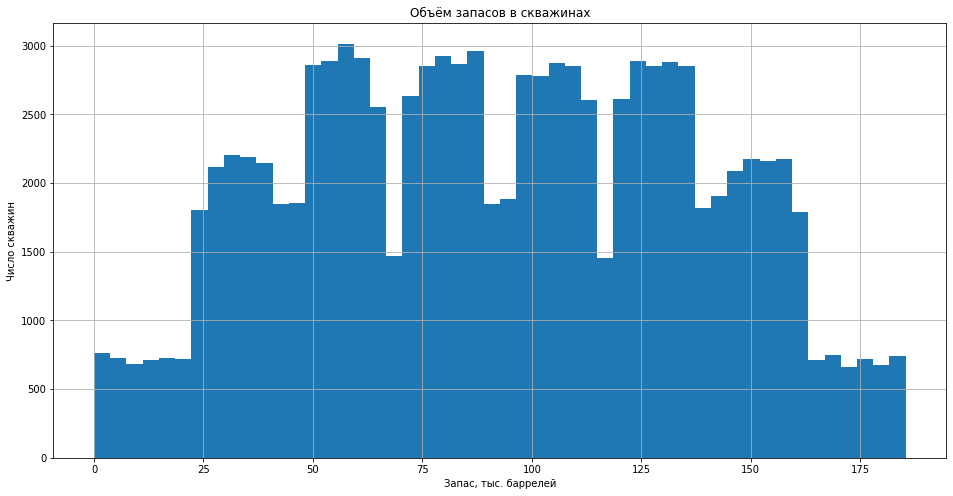

In [13]:
# Построим гистограмму распределения объёма запасов в скважинах.
geo_0['product'].hist(figsize=(16, 8), bins=50)
plt.title('Объём запасов в скважинах')
plt.xlabel('Запас, тыс. баррелей')
plt.ylabel('Число скважин')
plt.show()

In [14]:
# Рассмотрим статистические данные датафрейма geo_data_1.csv.
geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


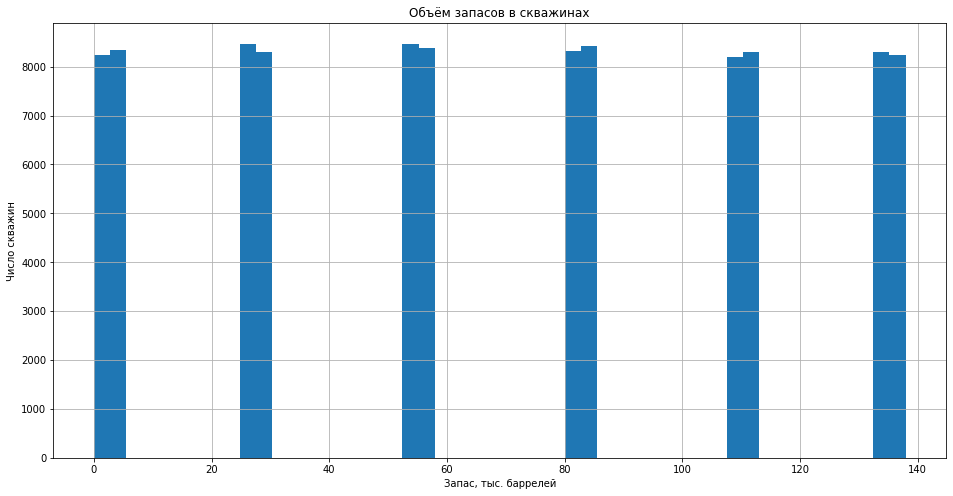

In [15]:
# Построим гистограмму распределения объёма запасов в скважинах.
geo_1['product'].hist(figsize=(16, 8), bins=50)
plt.title('Объём запасов в скважинах')
plt.xlabel('Запас, тыс. баррелей')
plt.ylabel('Число скважин')
plt.show()

In [16]:
# Рассмотрим статистические данные датафрейма geo_data_2.csv.
geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


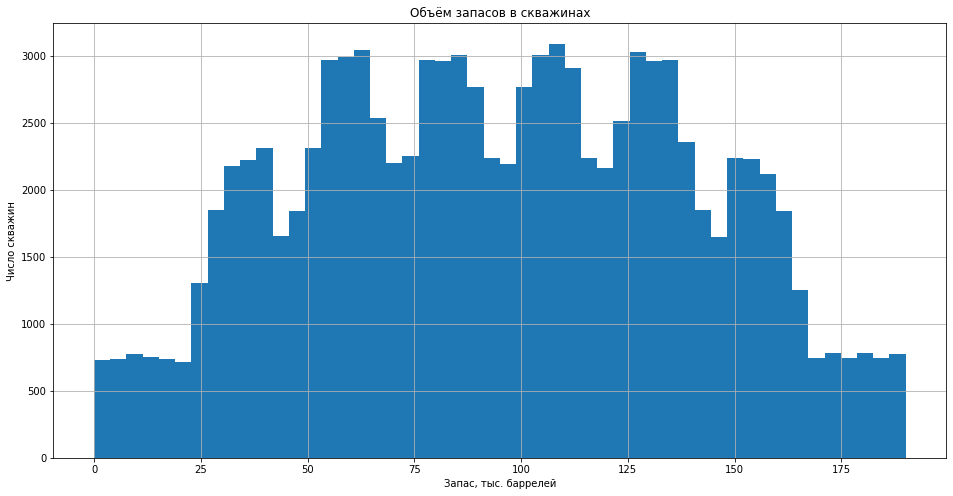

In [17]:
# Построим гистограмму распределения объёма запасов в скважинах.
geo_2['product'].hist(figsize=(16, 8), bins=50)
plt.title('Объём запасов в скважинах')
plt.xlabel('Запас, тыс. баррелей')
plt.ylabel('Число скважин')
plt.show()

**Промежуточный вывод:** Видим нормальные распределения в регионах 0 и 2. Распределение в регионе 1 выглядит нетипично, равномерно распределенно на одинаковых промежутках, будто сгенерированно искусственно или сгруппировано. В каждом регионе наблюдаются значения объемов, равные нулю. Возможно, данные скважины не были замерены, тем не менее, оставим их, так как возможности проконсультироваться с заказчиком нет, а данные могут быть полезны при обучении модели.

## Обучение и проверка модели

Согласно условию, для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

In [18]:
# Напишем функцию для разбивки данных, обучения модели и подсчета среднего запаса сырья,
# чтобы применить ее ко всем датафреймам.
def region_prediction(df):
    features = df.drop(['id', 'product'], axis=1)
    target = df['product']
    X_train, X_valid, y_train, y_valid = train_test_split(
        features, target, test_size=0.25, random_state=42)
    scaler = StandardScaler()
    features_train = scaler.fit_transform(X_train)
    features_valid = scaler.transform(X_valid)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    predictions = pd.Series(predictions)
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))
    stock_mean = predictions.mean()
    stock_mean_real = df['product'].mean()
    return predictions, rmse, stock_mean, stock_mean_real, y_valid.reset_index(drop=True)

### Средний запас сырья и RMSE модели для региона 0

In [19]:
predictions_0, rmse_0, stock_mean_0, stock_mean_real_0, y_valid_0 = region_prediction(geo_0)
print('Средний запас предсказанного сырья (тыс. баррелей):', round(stock_mean_0, 2))
print('Реальный средний запас сырья (тыс. баррелей):', round(stock_mean_real_0, 2))
print('RMSE региона:', round(rmse_0, 2))

Средний запас предсказанного сырья (тыс. баррелей): 92.4
Реальный средний запас сырья (тыс. баррелей): 92.5
RMSE региона: 37.76


### Средний запас сырья и RMSE модели для региона 1

In [20]:
predictions_1, rmse_1, stock_mean_1, stock_mean_real_1, y_valid_1 = region_prediction(geo_1)
print('Средний запас предсказанного сырья (тыс. баррелей):', round(stock_mean_1, 2))
print('Реальный средний запас сырья (тыс. баррелей):', round(stock_mean_real_1, 2))
print('RMSE региона:', round(rmse_1, 2))

Средний запас предсказанного сырья (тыс. баррелей): 68.71
Реальный средний запас сырья (тыс. баррелей): 68.83
RMSE региона: 0.89


### Средний запас сырья и RMSE модели для региона 2

In [21]:
predictions_2, rmse_2, stock_mean_2, stock_mean_real_2, y_valid_2 = region_prediction(geo_2)
print('Средний запас предсказанного сырья (тыс. баррелей):', round(stock_mean_2, 2))
print('Реальный средний запас сырья (тыс. баррелей):', round(stock_mean_real_2, 2))
print('RMSE региона:', round(rmse_2, 2))

Средний запас предсказанного сырья (тыс. баррелей): 94.77
Реальный средний запас сырья (тыс. баррелей): 95.0
RMSE региона: 40.15


**Промежуточный вывод:** Видим, что в регионах 2 и 0 выше средний запас сырья, чем в регионе 1. Однако, RMSE региона 1 гораздо ниже, следовательно предсказания модели точнее. Тем не менее, стоит учитывать возможную природу исходных данных региона 1.

## Подготовка к расчёту прибыли

In [22]:
# Сохраним ключевые переменные согласно условиям задачи.
# При разведке региона исследуют 500 точек:
explored_well_points = 500
# Из которых с помощью машинного обучения выбирают 200 лучших для разработки:
best_well_points = 200
# Бюджет на разработку скважин в регионе (руб):
budget = 10000000000
# Доход с каждой единицы продукта (руб):
income = 450000
# Максимальная вероятность убытков:
loss_prob = 0.025

In [23]:
# Рассчитайем достаточный объём сырья для безубыточной разработки новой скважины.
# Для этого разделим бюджет на доход за единицу на число отобранных скважин.
min_stock = round(budget / income / best_well_points, 2)
print('Минимальный объём сырья для безубыточной разработки в 200 лучших скважинах (тыс. баррелей):', min_stock)

Минимальный объём сырья для безубыточной разработки в 200 лучших скважинах (тыс. баррелей): 111.11


**Промежуточный вывод:** Минимальный объем сырья получился 111 тысяч баррелей - больше, чем средние значения объемов по регионам (92.4 для 0, 68.71 для 1 и 94.77 для 2 региона). Однако, стоит учитывать, что для разработки отберут только лучшие 200 из 500 исследованных точек.

## Расчёт прибыли и рисков

In [24]:
# Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.
def well_profit(target, predictions):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected_points = target[predictions_sorted.index][:best_well_points]
    revenue = selected_points.sum() * income - budget
    
    return revenue

In [25]:
# Рассчитаем прибыль для полученного объёма сырья из скважин с максимальными значениями предсказаний.
revenue_0 = well_profit(y_valid_0, predictions_0)
revenue_1 = well_profit(y_valid_1, predictions_1)
revenue_2 = well_profit(y_valid_2, predictions_2)

print('Прибыль в регионе 0, руб.:', round(revenue_0))
print('Прибыль в регионе 1, руб.:', round(revenue_1))
print('Прибыль в регионе 2, руб.:', round(revenue_2))

Прибыль в регионе 0, руб.: 3359141114
Прибыль в регионе 1, руб.: 2415086697
Прибыль в регионе 2, руб.: 2598571759


**Промежуточный вывод:** Видим, что наибольшую прибыль принесет регион 0: 3359141114 (3.36 млрд) рублей. За ним следует регион 2: 2598571759 (2.6 млрд) рублей. Наименьшую прибыль принесет регион 1: 2415086697 (2.4 млрд) рублей.

In [26]:
# Напишем функцию для расчета средней прибыли, доверительного интервала и риска убытков.
# Применим технику Bootstrap с 1000 выборок.
def bootstrap(target, predictions):
    state = np.random.RandomState(42)
    values = []
    loss = 0
    
    for i in range(1000):
        target_subsample = target.sample(n=explored_well_points, replace=True, random_state=state)
        preds_subsample = predictions[target_subsample.index]
        revenue = well_profit(target_subsample, preds_subsample)
        if revenue < 0:
            loss += 1
        values.append(revenue)
        
    values = pd.Series(values)
    mean_revenue = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk_of_loss = loss/len(values)*100
    
    return mean_revenue, lower, upper, risk_of_loss

### Средняя прибыль, доверительный интервал и риски для региона 0

In [27]:
mean_revenue_0, lower_0, upper_0, risk_of_loss_0 = bootstrap(y_valid_0, predictions_0)
print('Средняя прибыль в регионе 0, руб.:', round(mean_revenue_0))
print('95% доверительный интервал от', round(lower_0),'руб.', 'до', round(upper_0), 'руб.')
print('Риск убытков, %:', round(risk_of_loss_0, 2))

Средняя прибыль в регионе 0, руб.: 427847560
95% доверительный интервал от -97249830 руб. до 954215193 руб.
Риск убытков, %: 5.5


### Средняя прибыль, доверительный интервал и риски для региона 1

In [28]:
mean_revenue_1, lower_1, upper_1, risk_of_loss_1 = bootstrap(y_valid_1, predictions_1)
print('Средняя прибыль в регионе 0, руб.:', round(mean_revenue_1))
print('95% доверительный интервал от', round(lower_1),'руб.', 'до', round(upper_1), 'руб.')
print('Риск убытков, %:', round(risk_of_loss_1, 2))

Средняя прибыль в регионе 0, руб.: 511362776
95% доверительный интервал от 98870650 руб. до 940720512 руб.
Риск убытков, %: 0.9


### Средняя прибыль, доверительный интервал и риски для региона 2

In [29]:
mean_revenue_2, lower_2, upper_2, risk_of_loss_2 = bootstrap(y_valid_2, predictions_2)
print('Средняя прибыль в регионе 0, руб.:', round(mean_revenue_2))
print('95% доверительный интервал от', round(lower_2),'руб.', 'до', round(upper_2), 'руб.')
print('Риск убытков, %:', round(risk_of_loss_2, 2))

Средняя прибыль в регионе 0, руб.: 402575608
95% доверительный интервал от -137162225 руб. до 929887528 руб.
Риск убытков, %: 7.4


**Промежуточный вывод:** Согласно условию, после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью. Регион с вероятностью убытков ниже 2.5% только один - регион 1 (Риск убытков = 0.9%). Кроме того, его средняя прибыль самая высокая из трёх, так что бурить скважины следует именно в нём.

## Общий вывод

**Цель исследования:** Построили модель машинного обучения, которая помогла определить регион, где добыча принесёт наибольшую прибыль. Проанализировали возможную прибыль и риски техникой Bootstrap.

**Предобработка данных:** Данные соответствуют описанию задачи и общему оформлению с правильными типами данных. Обзор данных методом info() выявил пропуски. Проверка на дубликаты не обнаружила явные повторы.

**Исследовательский анализ данных:** Провели статистический анализ распределения объёма запасов в скважинах по регионам, построили графики. Увидели нормальные распределения в регионах 0 и 2. Распределение в регионе 1 выглядит нетипично, равномерно распределенно на одинаковых промежутках, будто сгенерированно искусственно или сгруппировано. В каждом регионе наблюдаются значения объемов, равные нулю. Возможно, данные скважины не были замерены, тем не менее, решили оставить их, так как данные могут быть полезны при обучении модели.

**Обучение и проверка модели:** Согласно условию, для обучения модели использовалась только линейная регрессия (остальные — недостаточно предсказуемые). Обучили и проверили валидационными выборками модель для всех регионов с помощью функции. Увидели, что в регионах 2 и 0 выше средний запас сырья, чем в регионе 1. Однако, RMSE региона 1 гораздо ниже, следовательно предсказания модели точнее. Тем не менее, стоит учитывать возможную природу исходных данных региона 1.

**Подготовка к расчёту прибыли:** Обозначили ключевые переменные согласно условиям задачи. Рассчитали достаточный объём сырья для безубыточной разработки новой скважины. Для этого разделили бюджет на доход за единицу на число отобранных скважин. Минимальный объем сырья получился 111 тысяч баррелей - больше, чем средние значения объемов по регионам (92.4 для 0, 68.71 для 1 и 94.77 для 2 региона). Однако, стоит учитывать, что для разработки отберут только лучшие 200 из 500 исследованных точек.

**Расчёт прибыли и рисков:** Написали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели, рассчитали прибыль для полученного объёма сырья из скважин с максимальными значениями предсказаний. Увидели, что наибольшую прибыль принесет регион 0: 3359141114 (3.36 млрд) рублей. За ним следует регион 2: 2598571759 (2.6 млрд) рублей. Наименьшую прибыль принесет регион 1: 2415086697 (2.4 млрд) рублей.

Написали функцию для расчета средней прибыли, доверительного интервала и риска убытков, применив технику Bootstrap с 1000 выборок, рассчитали значения. Согласно условию, после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью. Регион с вероятностью убытков ниже 2.5% только один - регион 1 (Риск убытков = 0.9%). Кроме того, его средняя прибыль самая высокая из трёх, так что бурить скважины следует именно в нём.

**Рекомендации:** Уточнить природу данных для региона 1 - аномальность данных могла привести к его выгодности. Возможно, стоит установить нижний порог объема запасов в скважине, чтобы не учитывать слишком бедные скважины при разработке.